<a href="https://colab.research.google.com/github/gagyeomkim/deepfake-defense-from-scratch/blob/gagyeomkim/code_practice/week8/fake_image_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **첫번째 구현 : fake image binary classification**

## **Summary**
- 데이터셋: https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection
- 사용 Model: SimpleCNN, pretrained model 하나
- 평가지표: 단순 Accuracy(정확도)

> 저희가 할일은, 이제부터 이 모델을 하나하나 고도화시켜나가는 것입니다

## **Dataset**

### 1) 데이터셋 설명


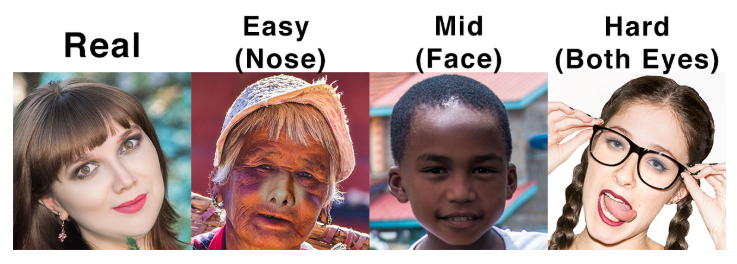

- 해당 데이터셋은 포토샵 합성 얼굴 이미지를 포함하고 있음
    - 이 이미지들은 눈, 코, 입 또는 전체 얼굴을 기준으로 여러 얼굴을 합성한 형태임
- fake image는 난이도에 따라 easy, mid, hard의 세 그룹으로 나뉨.

### 2) 데이터셋 분석

In [1]:
import os

In [2]:
!rm -rf real_and_fake_face *.zip

!pip install -q gdown

# 다운로드
!gdown --id 1HdZPlbS0ij7WC2EktYaJQU-g5gELZndy

# 압축 해제
!unzip -q *.zip

# 확인
!ls -lh real_and_fake_face

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1HdZPlbS0ij7WC2EktYaJQU-g5gELZndy
From (redirected): https://drive.google.com/uc?id=1HdZPlbS0ij7WC2EktYaJQU-g5gELZndy&confirm=t&uuid=aedabda4-ed86-49bb-b363-aa56d8df980f
To: /content/archive.zip
100% 226M/226M [00:02<00:00, 112MB/s]
total 80K
drwxr-xr-x 2 root root 36K Jan  3 15:52 training_fake
drwxr-xr-x 2 root root 36K Jan  3 15:52 training_real


In [3]:
# 이미지 개수 세기
!ls /content/real_and_fake_face/training_real | wc -l
!ls /content/real_and_fake_face/training_fake | wc -l

# fake image 카테고리마다 개수세기
!ls /content/real_and_fake_face/training_fake | grep -i easy | wc -l
!ls /content/real_and_fake_face/training_fake | grep -i mid | wc -l
!ls /content/real_and_fake_face/training_fake | grep -i hard | wc -l

1081
960
240
480
240


- Real image: 1081개
- fake image : 960개
    - easy : 240개
    - mid : 480개
    - hard : 240개

#### 데이터셋 시각화

In [4]:
real = "/content/real_and_fake_face/training_real/"
fake = "/content/real_and_fake_face/training_fake/"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

In [5]:
import cv2

def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    return image[..., ::-1]

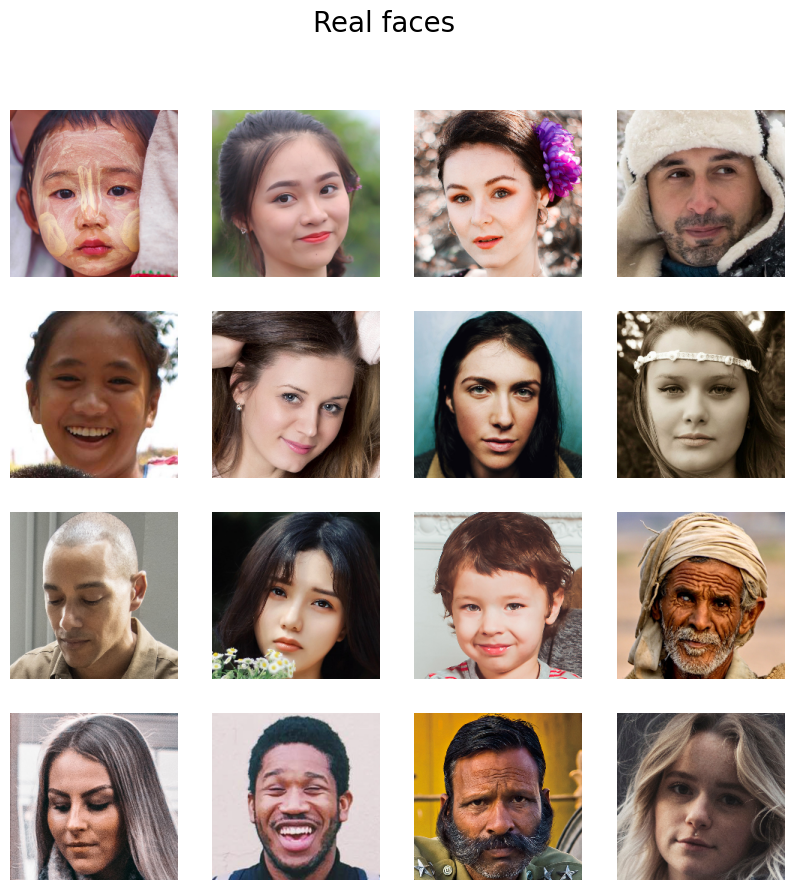

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')

plt.show()

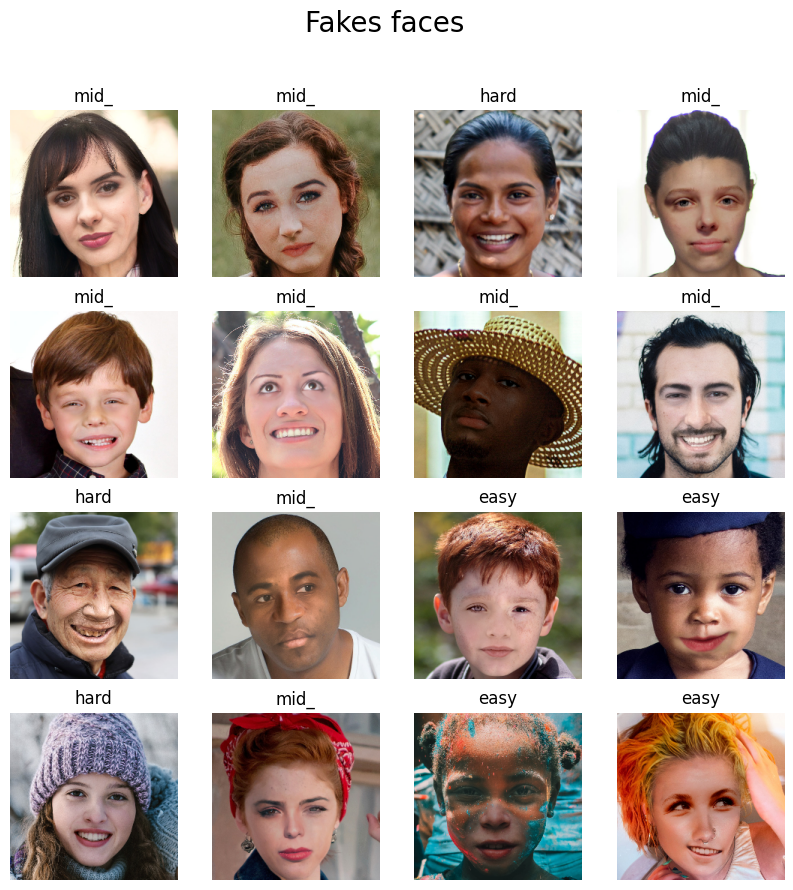

In [7]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.suptitle("Fakes faces",fontsize=20)
    plt.title(fake_path[i][:4])
    plt.axis('off')

plt.show()

얼굴이 대체적으로 중앙에 있는 것을 확인 가능  
-> deepfake detection에서 중요한 부분은 얼굴 부분이기 때문에, 이후에 중심부를 기준으로 사진을 crop할겁니다.

### 3) 데이터셋 분리

- 현재 data가 training과 test로 분리되어 있지 않음. 따라서 training set과 test set으로 data를 분리하여 라벨링할 것

In [9]:
import os
import random
import shutil

!rm -rf dataset

# --------------------
# 설정
# --------------------
SRC_ROOT = "/content/real_and_fake_face"
DST_ROOT = "/content/dataset"

SPLIT_RATIO = 0.2
SEED = 42

random.seed(SEED)

exts = (".jpg")

pairs = [
    # source, train_dest, test_dest
    ("training_real", "train/real", "test/real"),
    ("training_fake", "train/fake", "test/fake"),
]

# --------------------
# 디렉토리 생성
# --------------------
for _, train_dst, test_dst in pairs:
    os.makedirs(os.path.join(DST_ROOT, train_dst), exist_ok=True)
    os.makedirs(os.path.join(DST_ROOT, test_dst), exist_ok=True)

# --------------------
# split + 이동
# --------------------
for src_name, train_dst, test_dst in pairs:
    src_dir = os.path.join(SRC_ROOT, src_name)
    train_dir = os.path.join(DST_ROOT, train_dst)
    test_dir  = os.path.join(DST_ROOT, test_dst)

    files = [
        f for f in os.listdir(src_dir)
        if f.lower().endswith(exts)
    ]

    total = len(files)
    num_test = int(total * SPLIT_RATIO)

    random.shuffle(files)
    test_files = files[:num_test]
    train_files = files[num_test:]

    print(f"\n[{src_name}]")
    print(f"총 이미지 수: {total}")
    print(f"training: {len(train_files)}")
    print(f"test: {len(test_files)}")

    # training 이동
    for f in train_files:
        shutil.move(
            os.path.join(src_dir, f),
            os.path.join(train_dir, f)
        )

    # test 이동
    for f in test_files:
        shutil.move(
            os.path.join(src_dir, f),
            os.path.join(test_dir, f)
        )


[training_real]
총 이미지 수: 1081
training: 865
test: 216

[training_fake]
총 이미지 수: 960
training: 768
test: 192


학습을 하기에는 전체 데이터가 매우 적은 것을 확인 가능 -> 데이터 증강(data augmentation)을 수행해야함
> 데이터 증강은 궁금하신 분들은 찾아보기.. 간단히 말하자면 데이터가 매우 적을 때, 데이터를 인위적으로 늘리는 방법

### 4) dataFrame 생성

- 수치 데이터(2차원)가 아닌, 이미지 데이터(3차원)이기 때문에, 경로명을 column으로 가진 dataframe을 train과 test별로 제작할 것

In [86]:
import glob
import os
import pandas as pd

train_valid_image_paths = glob.glob("/content/dataset/train/*/*.jpg")
train_valid_df = pd.DataFrame({"path": train_valid_image_paths})

# label = 상위 폴더명 (real/fake)
train_valid_df["label"] = train_valid_df["path"].apply(lambda x: os.path.basename(os.path.dirname(x)))

print(train_valid_df.head())
print(train_valid_df["label"].value_counts())
print("train rows:", len(train_valid_df))

                                         path label
0  /content/dataset/train/real/real_00069.jpg  real
1  /content/dataset/train/real/real_00331.jpg  real
2  /content/dataset/train/real/real_00770.jpg  real
3  /content/dataset/train/real/real_01007.jpg  real
4  /content/dataset/train/real/real_00101.jpg  real
label
real    865
fake    768
Name: count, dtype: int64
train rows: 1633


In [87]:
import glob
import os
import pandas as pd

test_image_paths = glob.glob("/content/dataset/test/*/*.jpg")
test_df = pd.DataFrame({"path": test_image_paths})

# label = 상위 폴더명 (real/fake)
test_df["label"] = test_df["path"].apply(lambda x: os.path.basename(os.path.dirname(x)))

print(test_df.head())
print(test_df["label"].value_counts())
print("train rows:", len(test_df))

                                        path label
0  /content/dataset/test/real/real_00752.jpg  real
1  /content/dataset/test/real/real_00804.jpg  real
2  /content/dataset/test/real/real_01042.jpg  real
3  /content/dataset/test/real/real_00414.jpg  real
4  /content/dataset/test/real/real_01079.jpg  real
label
real    216
fake    192
Name: count, dtype: int64
train rows: 408


### 5) train_valid_df -> train_df, valid_df로 분리

- 하이퍼파라미터 조정용으로, validation set 준비

In [88]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(
    train_valid_df,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=train_valid_df["label"],
)

In [89]:
print(train_df.head())
print()
print(valid_df.head())
print()
print(test_df.head())

                                               path label
1286   /content/dataset/train/fake/mid_239_1011.jpg  fake
1597   /content/dataset/train/fake/easy_34_1100.jpg  fake
1165  /content/dataset/train/fake/easy_137_0001.jpg  fake
982   /content/dataset/train/fake/easy_232_1100.jpg  fake
161      /content/dataset/train/real/real_00190.jpg  real

                                               path label
42       /content/dataset/train/real/real_00530.jpg  real
1325   /content/dataset/train/fake/mid_122_1100.jpg  fake
1026  /content/dataset/train/fake/hard_179_1111.jpg  fake
1082   /content/dataset/train/fake/mid_161_0110.jpg  fake
1237   /content/dataset/train/fake/mid_201_1111.jpg  fake

                                        path label
0  /content/dataset/test/real/real_00752.jpg  real
1  /content/dataset/test/real/real_00804.jpg  real
2  /content/dataset/test/real/real_01042.jpg  real
3  /content/dataset/test/real/real_00414.jpg  real
4  /content/dataset/test/real/real_01079.jpg  r

In [90]:
print(train_df["label"].value_counts(normalize=True))
print(valid_df["label"].value_counts(normalize=True))

label
real    0.529862
fake    0.470138
Name: proportion, dtype: float64
label
real    0.529052
fake    0.470948
Name: proportion, dtype: float64


## Training

### 1) CustomDataset 설정

In [91]:
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        img = Image.open(img_path).convert("RGB")

        # real: 0, fake: 1
        label = 0 if self.dataframe.iloc[idx, 1] == "real" else 1

        if self.transform:
            img = self.transform(img)

        return img, label

In [48]:
# import numpy as np
# from PIL import Image
# from torchvision import transforms
# from torch.utils.data import DataLoader

# def compute_overall_mean_std(df):
#     """
#         df: train set용 dataframe
#         train 데이터셋 전체에서 RGB 채널별 평균(mean)과 표준편차(std)를 픽셀 단위로 계산한다.
#     """
#     channel_sum = np.zeros(3, dtype=np.float64) # 채널 c(R,G,B)의 모든 픽셀값 합
#     channel_sq_sum = np.zeros(3, dtype=np.float64) # 채널 c의 픽셀값 제곱의 합
#     pixel_count = 0 # 전체 픽셀 개수 = (H×W×이미지 수)

#     for _, row in df.iterrows():
#         img = Image.open(row["path"]).convert("RGB")
#         img = np.asarray(img, dtype=np.float32) / 255.0  # [0,1]

#         h, w, _ = img.shape
#         pixel_count += h * w

#         channel_sum += img.sum(axis=(0, 1))
#         channel_sq_sum += (img ** 2).sum(axis=(0, 1))

#     mean = channel_sum / pixel_count    # 기댓값 계산
#     std = np.sqrt(channel_sq_sum / pixel_count - mean ** 2) # 표준편차 공식

#     return mean.tolist(), std.tolist()

# # train만으로 mean/std 계산
# normalized_channel_means, normalized_channel_stds = compute_overall_mean_std(train_df)
# print(f"normalized_channel_means: {normalized_channel_means}")
# print(f"normalized_channel_stds: {normalized_channel_stds}")

In [99]:
# 계산이 오래 걸리므로, 미리 계산된 값을 이용할 것
normalized_channel_means = [0.5159901929579159, 0.43138779010237205, 0.38887346908831566]
normalized_channel_stds = [0.2922462811984076, 0.2667907590120976, 0.26435657587983385]

### 2) 전처리 및 (data augmentation)

- augmentation은 다음주 성능향상 부분에서 알아봅시다

In [100]:
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# data augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalized_channel_means, std=normalized_channel_stds),
])

eval_transform = transforms.Compose([
    transforms.Resize(256), # 짧은 변을 256으로 맞춤
    transforms.CenterCrop(224), # 중앙의 224 x 224만 사용
    transforms.ToTensor(),
    transforms.Normalize(mean=normalized_channel_means, std=normalized_channel_stds),
])

# 데이터셋 로딩
train_dataset = CustomDataset(dataframe=train_df, transform=train_transform)
valid_dataset = CustomDataset(dataframe=valid_df, transform=eval_transform)
test_dataset  = CustomDataset(dataframe=test_df, transform=eval_transform)

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [101]:
total_batch = len(train_loader)
print('총 배치의 수 : {}'.format(total_batch))

total_batch = len(valid_loader)
print('총 배치의 수 : {}'.format(total_batch))

total_batch = len(test_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 41
총 배치의 수 : 11
총 배치의 수 : 13


### architecture1: SimpleCNN

In [108]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, keep_prob=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )

        self.fc = nn.Linear(256, 2)  # 2-class logits
        nn.init.xavier_uniform_(self.fc.weight)

        self.classifier = nn.Sequential(
            nn.Dropout(p=1 - keep_prob),
            self.fc
        )

    def forward(self, x):
        x = self.features(x)          # (B, 256, 1, 1)
        x = torch.flatten(x, 1)       # (B, 256)
        x = self.classifier(x)        # (B, 2)
        return x

In [109]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
LR = 1e-3
EPOCHS=50

In [110]:
from tqdm import tqdm

best_val_acc = 0.0
patience = 5
no_improve = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", dynamic_ncols=True):
        inputs = inputs.to(device)
        labels = labels.to(device).long()    # ✅ CE는 long

        optimizer.zero_grad()
        logits = model(inputs)               # (B, 2)
        loss = criterion(logits, labels)     # ✅ 그대로 넣음

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(logits, dim=1)  # ✅ argmax
        total_train += labels.size(0)
        correct_train += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train

    # Validate
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            logits = model(inputs)
            loss = criterion(logits, labels)
            running_val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            total_val += labels.size(0)
            correct_val += (preds == labels).sum().item()

    val_loss = running_val_loss / len(valid_loader)
    val_acc = correct_val / total_val

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping + best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_after.pth")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping")
            break

print("Finished Training")


Epoch 1/50: 100%|██████████| 41/41 [00:17<00:00,  2.34it/s]


Train Loss: 0.6960, Train Acc: 0.5000 | Val Loss: 0.6916, Val Acc: 0.5291


Epoch 2/50: 100%|██████████| 41/41 [00:14<00:00,  2.82it/s]


Train Loss: 0.6918, Train Acc: 0.5283 | Val Loss: 0.6912, Val Acc: 0.5291


Epoch 3/50: 100%|██████████| 41/41 [00:14<00:00,  2.80it/s]


Train Loss: 0.6922, Train Acc: 0.5299 | Val Loss: 0.6910, Val Acc: 0.5291


Epoch 4/50: 100%|██████████| 41/41 [00:14<00:00,  2.77it/s]


Train Loss: 0.6928, Train Acc: 0.5130 | Val Loss: 0.6914, Val Acc: 0.5291


Epoch 5/50: 100%|██████████| 41/41 [00:14<00:00,  2.88it/s]


Train Loss: 0.6923, Train Acc: 0.5299 | Val Loss: 0.6909, Val Acc: 0.5291


Epoch 6/50: 100%|██████████| 41/41 [00:14<00:00,  2.88it/s]


Train Loss: 0.6918, Train Acc: 0.5276 | Val Loss: 0.6911, Val Acc: 0.5291
Early stopping
Finished Training


지금보면, 모델이 학습이 거의 안되고 있는것을 확인가능.
-> pretrained model로 변경하는 것이 유리

**Q. 왜 단순한 모델을 썼을 때는 학습이 잘 안될까?**

> 이거 생각해보기

### arthitecture2: Pretrained model

In [128]:
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# data augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalized_channel_means, std=normalized_channel_stds),
])

eval_transform = transforms.Compose([
    transforms.Resize(256), # 짧은 변을 256으로 맞춤
    transforms.CenterCrop(224), # 중앙의 224 x 224만 사용
    transforms.ToTensor(),
    transforms.Normalize(mean=normalized_channel_means, std=normalized_channel_stds),
])

# 데이터셋 로딩
train_dataset = CustomDataset(dataframe=train_df, transform=train_transform)
valid_dataset = CustomDataset(dataframe=valid_df, transform=eval_transform)
test_dataset  = CustomDataset(dataframe=test_df, transform=eval_transform)

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [129]:
from torchvision import datasets, models, transforms

# 사전 학습된 ResNet18 모델 불러오기
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# 모델의 마지막 완전 연결 계층(fc)을 사용자 정의 계층으로 대체
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2), # 이진분류
)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
LR = 1e-3
EPOCHS=50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [130]:
from tqdm import tqdm

best_val_acc = 0.0
patience = 5
no_improve = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []


for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", dynamic_ncols=True):
        inputs = inputs.to(device)
        labels = labels.to(device).long()    # ✅ CE는 long

        optimizer.zero_grad()
        logits = model(inputs)               # (B, 2)
        loss = criterion(logits, labels)     # ✅ 그대로 넣음

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(logits, dim=1)  # ✅ argmax
        total_train += labels.size(0)
        correct_train += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train

    # Validate
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            logits = model(inputs)
            loss = criterion(logits, labels)
            running_val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            total_val += labels.size(0)
            correct_val += (preds == labels).sum().item()

    val_loss = running_val_loss / len(valid_loader)
    val_acc = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping + best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_after.pth")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping")
            break

print("Finished Training")


Epoch 1/50: 100%|██████████| 41/41 [00:13<00:00,  3.02it/s]


Train Loss: 0.7848, Train Acc: 0.5819 | Val Loss: 1.3535, Val Acc: 0.5199


Epoch 2/50: 100%|██████████| 41/41 [00:13<00:00,  3.00it/s]


Train Loss: 0.6023, Train Acc: 0.6953 | Val Loss: 0.6764, Val Acc: 0.6239


Epoch 3/50: 100%|██████████| 41/41 [00:13<00:00,  2.96it/s]


Train Loss: 0.5042, Train Acc: 0.7534 | Val Loss: 0.8620, Val Acc: 0.5810


Epoch 4/50: 100%|██████████| 41/41 [00:14<00:00,  2.75it/s]


Train Loss: 0.4488, Train Acc: 0.8040 | Val Loss: 1.7341, Val Acc: 0.4862


Epoch 5/50: 100%|██████████| 41/41 [00:17<00:00,  2.39it/s]


Train Loss: 0.3479, Train Acc: 0.8530 | Val Loss: 0.8802, Val Acc: 0.6269


Epoch 6/50: 100%|██████████| 41/41 [00:13<00:00,  2.96it/s]


Train Loss: 0.3052, Train Acc: 0.8660 | Val Loss: 1.1454, Val Acc: 0.6361


Epoch 7/50: 100%|██████████| 41/41 [00:13<00:00,  2.99it/s]


Train Loss: 0.2306, Train Acc: 0.9035 | Val Loss: 1.0258, Val Acc: 0.6300


Epoch 8/50: 100%|██████████| 41/41 [00:13<00:00,  2.98it/s]


Train Loss: 0.1822, Train Acc: 0.9257 | Val Loss: 1.1707, Val Acc: 0.6239


Epoch 9/50: 100%|██████████| 41/41 [00:13<00:00,  3.02it/s]


Train Loss: 0.1430, Train Acc: 0.9479 | Val Loss: 1.7667, Val Acc: 0.5872


Epoch 10/50: 100%|██████████| 41/41 [00:13<00:00,  2.98it/s]


Train Loss: 0.1386, Train Acc: 0.9495 | Val Loss: 1.6273, Val Acc: 0.5933


Epoch 11/50: 100%|██████████| 41/41 [00:14<00:00,  2.92it/s]


Train Loss: 0.1040, Train Acc: 0.9625 | Val Loss: 1.2616, Val Acc: 0.6330
Early stopping
Finished Training


- pretrained model로 변경하니, 제대로 학습이 되는 것을 확인 가능

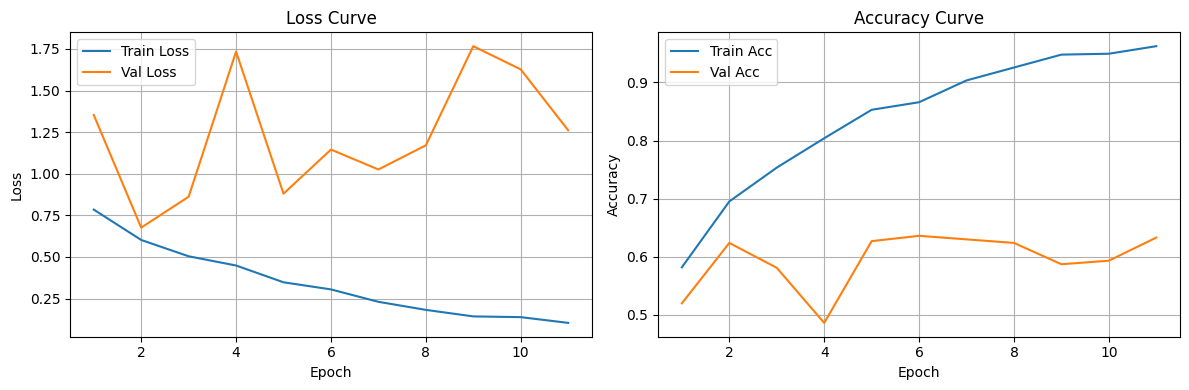

In [132]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


- 현재로써는 2 Epoch 또는 6 epoch 지점에서 학습을 멈추는 것이 좋아보임

## Inference

In [133]:
import torch

def evaluate_on_test(model, test_loader, device):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            logits = model(inputs)              # (B, 2)
            preds = torch.argmax(logits, dim=1) # (B,)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    acc = (all_preds == all_labels).float().mean().item()
    print(f"Test Accuracy: {acc:.4f}")

    return all_preds, all_labels

test_preds, test_labels = evaluate_on_test(model, test_loader, device)

Test Accuracy: 0.6348


- 정확도는 0.63, 즉 63%의 정확도를 가집니다.
- 생각보다 정확도가 꽤 낮은걸 확인할 수 있는데, 이제 저희가 할일은 이 정확도를 점차 올려가는 작업입니다!

### 추가적인 시각화
이번엔 실제로 사진을 보면서, 잘 예측이 되고 있는지 살펴봅시다

In [147]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def show_correct_incorrect_examples_with_filename(
    model,
    df,
    device,
    num_correct=4,
    num_incorrect=4,
    mean=None,
    std=None,
):
    model.eval()
    mean = np.array(mean, dtype=np.float32)
    std  = np.array(std, dtype=np.float32)

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
    ])

    correct_samples = []
    incorrect_samples = []

    with torch.no_grad():
        for _, row in df.iterrows():
            img_path = row["path"]
            filename = os.path.basename(img_path)
            gt_label = 0 if row["label"] == "real" else 1

            img = Image.open(img_path).convert("RGB")
            x = transform(img).unsqueeze(0).to(device)

            logits = model(x)
            probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
            pred = int(np.argmax(probs))
            conf = float(probs[pred])

            record = {
                "img": x[0].cpu(),
                "gt": gt_label,
                "pred": pred,
                "conf": conf,
                "filename": filename,
            }

            if pred == gt_label:
                correct_samples.append(record)
            else:
                incorrect_samples.append(record)

    # 랜덤 샘플
    correct_show = random.sample(correct_samples, min(num_correct, len(correct_samples)))
    incorrect_show = random.sample(incorrect_samples, min(num_incorrect, len(incorrect_samples)))

    print(f"Correct samples: {len(correct_samples)}")
    print(f"Incorrect samples: {len(incorrect_samples)}")

    def show(records, title_prefix):
        for r in records:
            img_np = r["img"].permute(1, 2, 0).numpy()
            img_np = img_np * std + mean
            img_np = np.clip(img_np, 0, 1)

            plt.imshow(img_np)
            plt.title(
                f"{title_prefix}\n"
                f"{r['filename']}\n"
                f"GT: {'Real' if r['gt']==0 else 'Fake'} | "
                f"Pred: {'Real' if r['pred']==0 else 'Fake'} "
                f"({r['conf']:.2f})",
                fontsize=9
            )
            plt.axis("off")
            plt.show()

    print("\n✅ Correct predictions")
    show(correct_show, "CORRECT")

    print("\n❌ Incorrect predictions")
    show(incorrect_show, "WRONG")


Correct samples: 259
Incorrect samples: 149

✅ Correct predictions


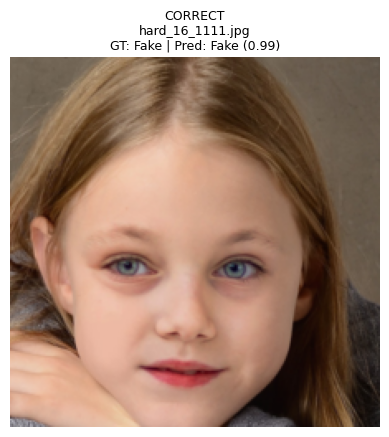

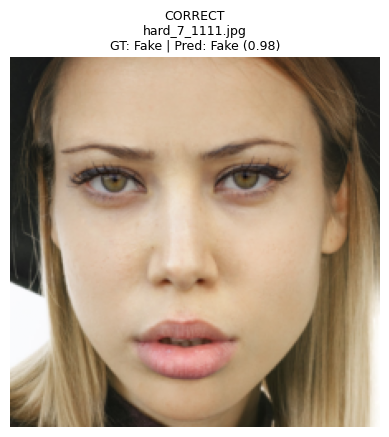

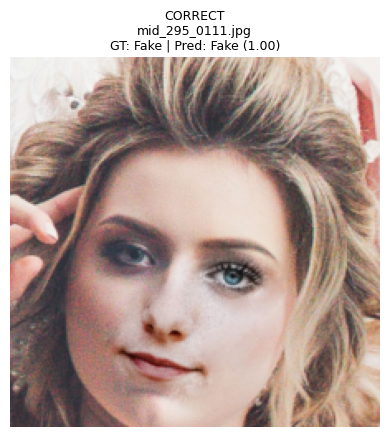

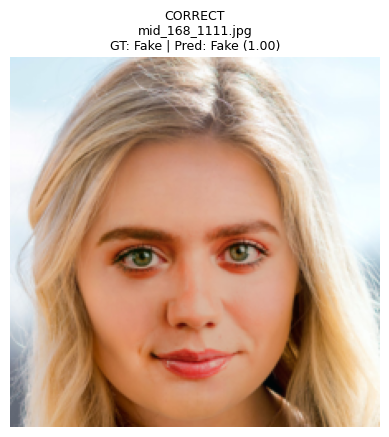

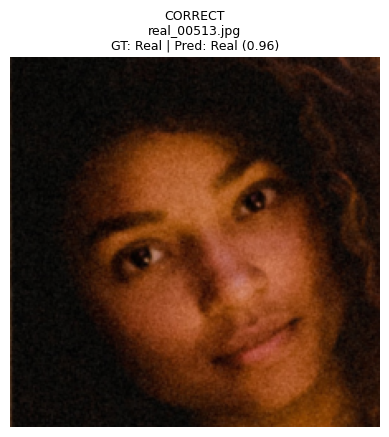

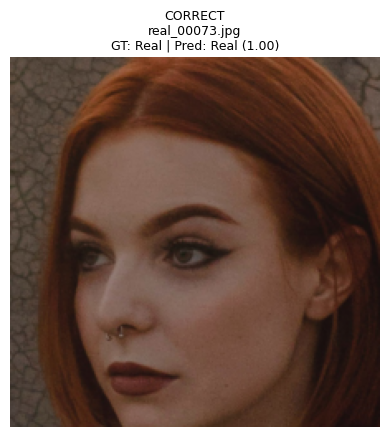

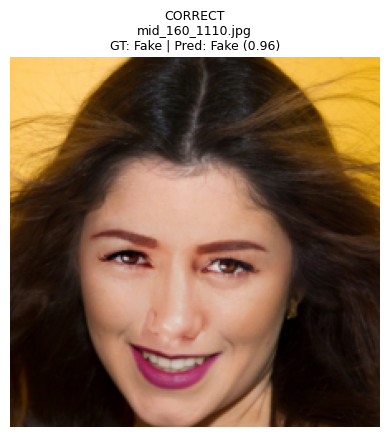

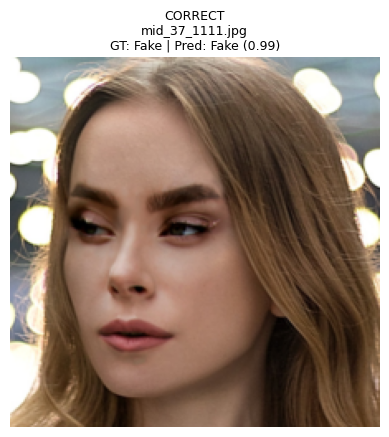

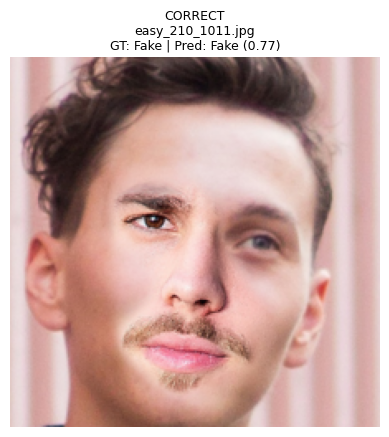

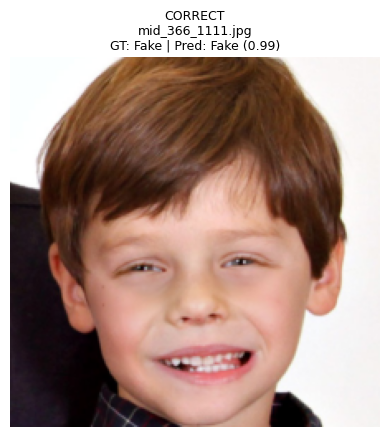


❌ Incorrect predictions


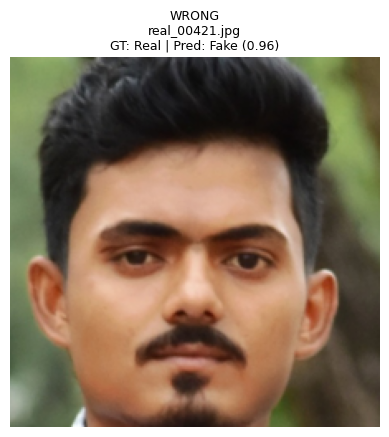

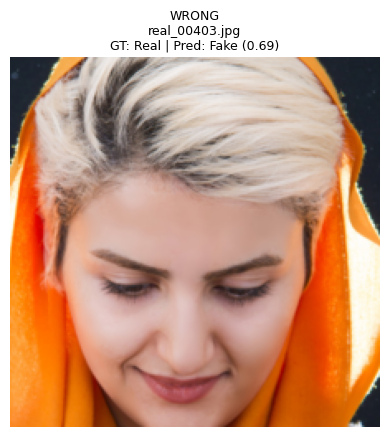

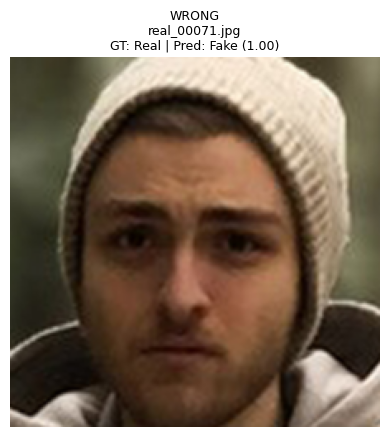

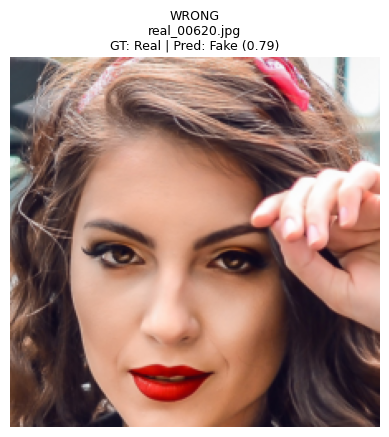

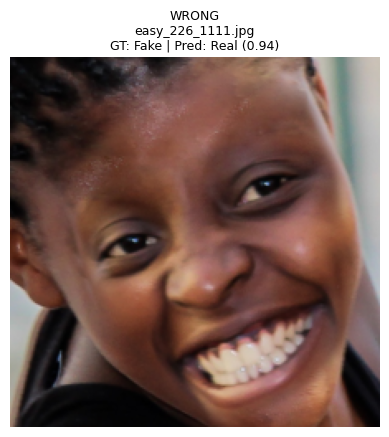

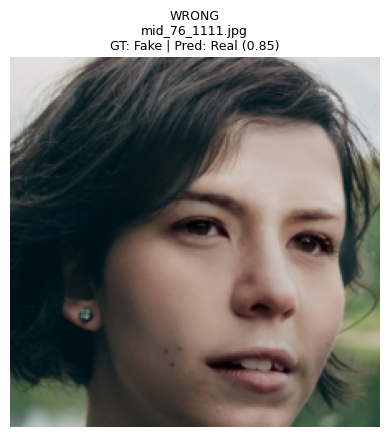

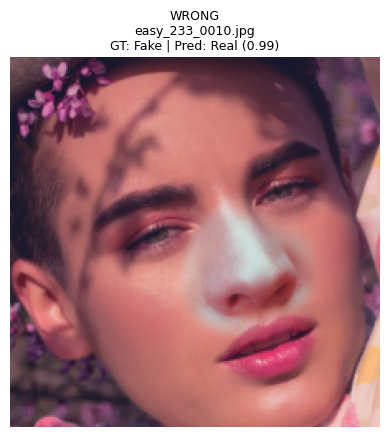

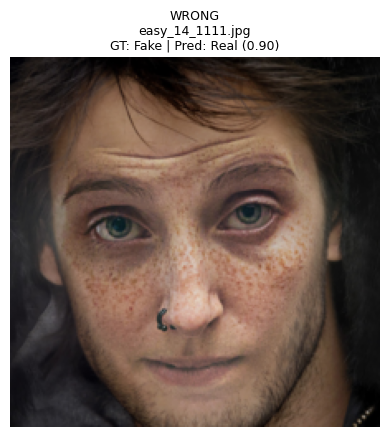

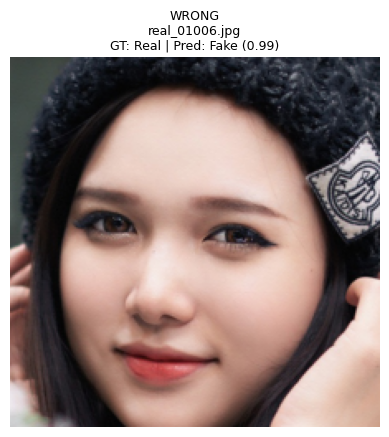

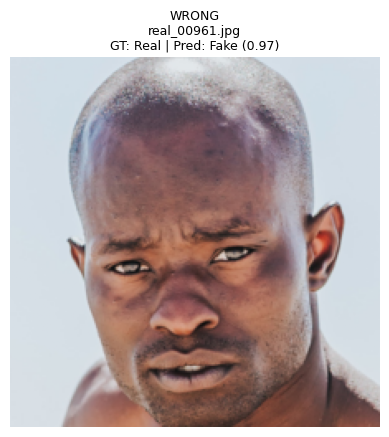

In [149]:
show_correct_incorrect_examples_with_filename(
    model,
    test_df,
    device,
    num_correct=10,
    num_incorrect=10,
    mean=normalized_channel_means,
    std=normalized_channel_stds
)


- 결과를 보면 희한하게 어려운 이미지를 잘 분류하는데, 쉬운걸 틀릴때도 있고 그럽니다.

- **Q. 왜 이런 결과가 일어날까요?**
>  이거 생각해보기

### (참고) 다양한 평가지표들

- 정확도 말고도 배운 평가지표를 단순 시각화만 해보겠습니다.(분석은 다음주에)

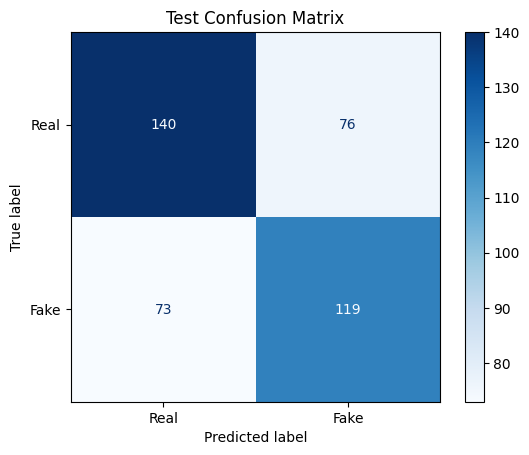

In [134]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Real", "Fake"]
)

disp.plot(cmap="Blues")
plt.title("Test Confusion Matrix")
plt.show()


In [135]:
from sklearn.metrics import roc_auc_score

model.eval()
all_probs = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        logits = model(inputs)
        probs = torch.softmax(logits, dim=1)[:, 1]  # Fake 확률
        all_probs.append(probs.cpu())

all_probs = torch.cat(all_probs)

auc = roc_auc_score(test_labels.numpy(), all_probs.numpy())
print(f"Test AUC: {auc:.4f}")


Test AUC: 0.6945
